# Find Classwise Accuracy

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import sys
sys.path.append("../utils/.")


import tensorflow as tf
#tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from utils import *

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

1

In [2]:
multi_step = True
model_path = "trained_models_acc/multistep/LSTM3_10steps.h5"

# Load the dataset

In [3]:
dataset = np.load('../data/acc/compressed/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [4]:
richters_path = "../data/metadata/richters.npy"
richters = np.load(richters_path)
print(len(richters))
print(min(richters), max(richters))

classes = [0, 1, 2, 3]
richters_discrete = np.zeros_like(richters)
richters_discrete += np.where(richters >= 5., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 3., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 1., np.ones_like(richters), np.zeros_like(richters))

35679
-0.49 7.1


Text(0, 0.5, 'Num Earthquakes')

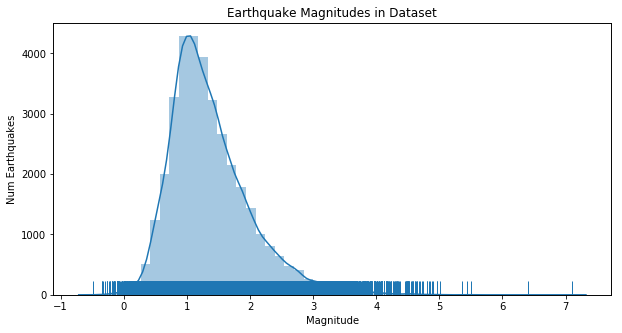

In [5]:
# Characterize the magnitudes
import seaborn as sns
f,ax1 = plt.subplots(figsize=(10, 5))
sns.distplot(richters,kde=False,ax=ax1, rug=True)
ax2 = ax1.twinx()
ax2.yaxis.set_ticks([])
sns.kdeplot(richters,ax=ax2)
plt.title("Earthquake Magnitudes in Dataset")
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Num Earthquakes')

In [6]:
dataset, richters_discrete = shuffle_together(dataset, richters_discrete, seed=10)

In [7]:
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)

print("Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):")
print("Train set: ", [np.sum(richters_discrete[:TRAIN_SPLIT_IDX] == i) for i in range(4)])
print("Val set: ", [np.sum(richters_discrete[TRAIN_SPLIT_IDX:] == i) for i in range(4)])


Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):
Train set:  [8560, 19193, 786, 4]
Val set:  [2168, 4778, 188, 2]


In [8]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

In [9]:
# def multivariate_data(dataset, history_size,
#                       target_size, step, single_step=False):
#     data = []
#     labels = []
    
#     start_index = history_size
#     end_index = dataset.shape[1] - target_size
        
#     for quake in dataset:

#         for i in range(start_index, end_index):
#             indices = range(i-history_size, i, step)
#             data.append(quake[indices])

#             if single_step:
#                 labels.append(quake[i+target_size])
#             else:
#                 labels.append(quake[i:i+target_size])

#     return np.array(data), np.array(labels)

# Segment earthquakes by magnitude

(array([1.0728e+04, 0.0000e+00, 0.0000e+00, 2.3971e+04, 0.0000e+00,
        0.0000e+00, 9.7400e+02, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

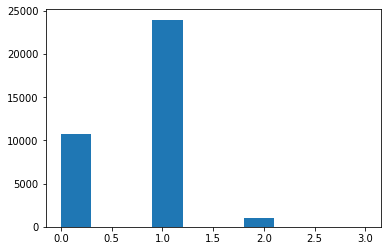

In [10]:
plt.hist(richters_discrete)

In [11]:
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)
val_dataset = dataset[TRAIN_SPLIT_IDX:]
val_richters_discrete = richters_discrete[TRAIN_SPLIT_IDX:]
val_data_mean = data_mean[TRAIN_SPLIT_IDX:]
val_data_var = data_var[TRAIN_SPLIT_IDX:]


quakes0 = val_dataset[val_richters_discrete == 0]
val_data_mean0 = val_data_mean[val_richters_discrete == 0]
val_data_var0 = val_data_var[val_richters_discrete == 0]

quakes1 = val_dataset[val_richters_discrete == 1]
val_data_mean1 = val_data_mean[val_richters_discrete == 1]
val_data_var1 = val_data_var[val_richters_discrete == 1]

quakes2 = val_dataset[val_richters_discrete == 2]
val_data_mean2 = val_data_mean[val_richters_discrete == 2]
val_data_var2 = val_data_var[val_richters_discrete == 2]

quakes3 = val_dataset[val_richters_discrete == 3]
val_data_mean3 = val_data_mean[val_richters_discrete == 3]
val_data_var3 = val_data_var[val_richters_discrete == 3]

len(quakes0), len(quakes1), len(quakes2), len(quakes3)

(2168, 4778, 188, 2)

In [12]:
past_history = 15
# future_target = 5 if multi_step else 1
future_target = 10 if multi_step else 1
STEP = 1

x_0, y_0 = multivariate_data(quakes0,past_history,
                                                   future_target, STEP,
                                                   single_step=not multi_step)
x_1, y_1 = multivariate_data(quakes1,past_history,
                                                   future_target, STEP,
                                                   single_step=not multi_step)
x_2, y_2 = multivariate_data(quakes2,past_history,
                                                   future_target, STEP,
                                                   single_step=not multi_step)
x_3, y_3 = multivariate_data(quakes3,past_history,
                                                   future_target, STEP,
                                                   single_step=not multi_step)

x_0.shape, x_1.shape, x_2.shape, x_3.shape 

((75880, 15, 15), (167230, 15, 15), (6580, 15, 15), (70, 15, 15))

In [13]:
y_0.shape

(75880, 10, 15)

# Load the model

### Single-step

In [14]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_0.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
single_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(75 if multi_step else 15))

single_step_model.load_weights(model_path)

single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
single_step_model.summary()

y_pred_0 = single_step_model.predict(x_0, batch_size = 4096)
y_pred_1 = single_step_model.predict(x_1, batch_size = 4096)
y_pred_2 = single_step_model.predict(x_2, batch_size = 4096)
y_pred_3 = single_step_model.predict(x_3, batch_size = 4096)

Instructions for updating:
Colocations handled automatically by placer.


ValueError: Shapes (15, 256) and (15, 512) are incompatible

### Multi-step

In [42]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_0.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target*past_history))

multi_step_model.load_weights(model_path)

multi_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
multi_step_model.summary()

y_pred_0 = multi_step_model.predict(x_0, batch_size = 4096).reshape((x_0.shape[0], -1, 15))[:, -1, :]
y_pred_1 = multi_step_model.predict(x_1, batch_size = 4096).reshape((x_1.shape[0], -1, 15))[:, -1, :]
y_pred_2 = multi_step_model.predict(x_2, batch_size = 4096).reshape((x_2.shape[0], -1, 15))[:, -1, :]
y_pred_3 = multi_step_model.predict(x_3, batch_size = 4096).reshape((x_3.shape[0], -1, 15))[:, -1, :]

y_0 = y_0[:, -1, :]
y_1 = y_1[:, -1, :]
y_2 = y_2[:, -1, :]
y_3 = y_3[:, -1, :]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 15, 128)           73728     
_________________________________________________________________
lstm_13 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               9750      
Total params: 165,910
Trainable params: 165,910
Non-trainable params: 0
_________________________________________________________________


In [43]:
print(y_pred_0.shape, y_pred_1.shape, y_pred_2.shape, y_pred_3.shape)

(75880, 15) (167230, 15) (6580, 15) (70, 15)


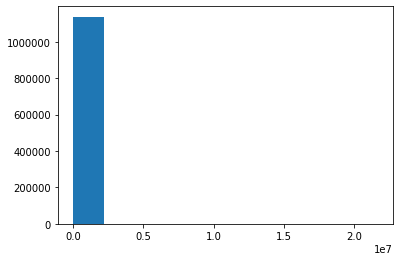

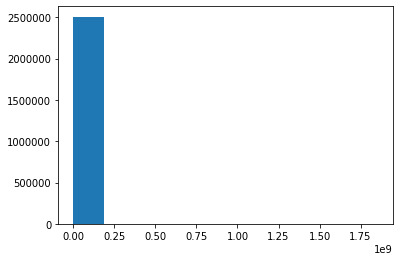

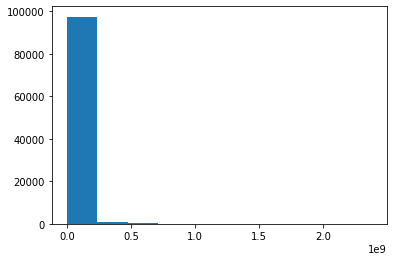

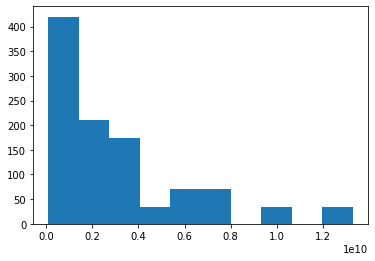

In [44]:
y_0, y_pred_0, delta_0 = recover_quake(y_pred_0, y_0, val_data_mean0, val_data_var0, len(quakes0))
y_1, y_pred_1, delta_1 = recover_quake(y_pred_1, y_1, val_data_mean1, val_data_var1, len(quakes1))
y_2, y_pred_2, delta_2 = recover_quake(y_pred_2, y_2, val_data_mean2, val_data_var2, len(quakes2))
y_3, y_pred_3, delta_3 = recover_quake(y_pred_3, y_3, val_data_mean3, val_data_var3, len(quakes3))

plt.figure()
plt.hist(delta_0)
plt.show()

plt.figure()
plt.hist(delta_1)
plt.show()

plt.figure()
plt.hist(delta_2)
plt.show()

plt.figure()
plt.hist(delta_3)
plt.show()

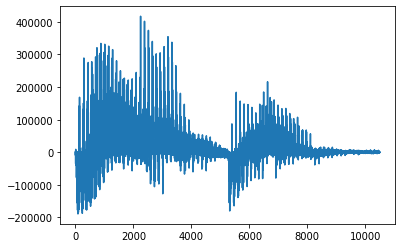

In [36]:
plt.plot(delta_3)
plt.show()

In [37]:
delta_3.shape

(10500,)

In [21]:
delta_0.shape

(11382000,)

In [47]:
def mae(delta):
    return np.mean(np.abs(delta))
mae(delta_0), mae(delta_1), mae(delta_2), mae(delta_3)

(2456.505137651211, 210679.04251220662, 11952909.33265154, 2959383195.895107)

In [48]:
mae(delta_0)/np.mean(val_data_var0), mae(delta_1)/np.mean(val_data_var1), mae(delta_2)/np.mean(val_data_var2), mae(delta_3)/np.mean(val_data_var3)

(63.67665132279604, 981.4271538303974, 1977.8099553238198, 9417.537146257033)

In [49]:
from sklearn import metrics

for y_true, y_pred in zip([y_0, y_1, y_2, y_3], [y_pred_0, y_pred_1, y_pred_2, y_pred_3]):
    print(y_pred.shape)
    y_true = y_true[:, -1, :].reshape((-1))
    y_pred = y_pred[:, -1, :].reshape((-1))

    print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
    print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
    print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
    print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
    print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
    print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

(2168, 35, 15)
Explained Variance Score: 1.818025930422351e-05
Max Error Score: 21680150.423668534
Mean Absolute Error Score: 2456.845411694634
Mean Squared Error Score: 15037425739.231228
Median Absolute Error Score: 30.69660070309748
R2 Score: -0.0003833780615658533
(4778, 35, 15)
Explained Variance Score: 3.7074884136067965e-06
Max Error Score: 1855030037.4573417
Mean Absolute Error Score: 210682.88815725577
Mean Squared Error Score: 159382636907722.53
Median Absolute Error Score: 188.72356987850202
R2 Score: -0.0002748641238101701
(188, 35, 15)
Explained Variance Score: 1.7180030282615277e-05
Max Error Score: 2377177719.3118577
Mean Absolute Error Score: 11953053.92247261
Mean Squared Error Score: 5981289444025951.0
Median Absolute Error Score: 85193.24049548406
R2 Score: -0.02445402817260378
(2, 35, 15)
Explained Variance Score: 3.163064806632754e-06
Max Error Score: 13307216859.537344
Mean Absolute Error Score: 2959408273.2379093
Mean Squared Error Score: 1.8982746458780738e+19
M

In [34]:
overall_mae = x_0.shape[0]*mae(delta_0)/np.mean(val_data_var0) + x_1.shape[0] * mae(delta_1)/np.mean(val_data_var1) + x_2.shape[0]*mae(delta_2)/np.mean(val_data_var2) + x_3.shape[0]*mae(delta_3)/np.mean(val_data_var3)
overall_mae /= (x_0.shape[0] + x_1.shape[0] + x_2.shape[0] + x_3.shape[0])
overall_mae

0.05619508965883455

In [24]:
r2 = 0
for num, y_true, y_pred in zip([x_0.shape[0], x_1.shape[0], x_2.shape[0]], [y_0, y_1, y_2], [y_pred_0, y_pred_1, y_pred_2]):
    r2 += num*metrics.r2_score(y_true, y_pred)
    
print("Total R2: ", r2 / sum([x_0.shape[0], x_1.shape[0], x_2.shape[0]]))

Total R2:  0.45173256379232474
